<a href="https://www.kaggle.com/code/oscarm524/ps-s5-ep5-eda-modeling-submission?scriptVersionId=237315743" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Loading Libraries

In [1]:
%%time
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import gc

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import matplotlib.ticker as ticker
import seaborn as sns

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, RepeatedKFold, RepeatedStratifiedKFold, GroupKFold
from sklearn.inspection import PartialDependenceDisplay
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR

from ydf import RandomForestLearner, GradientBoostedTreesLearner
import ydf

from lightgbm import LGBMRegressor

import xgboost as xgb
from xgboost import XGBRegressor

from catboost import CatBoostRegressor, Pool

CPU times: user 5.4 s, sys: 1.6 s, total: 6.99 s
Wall time: 9.84 s


# Reading Data Files

In [2]:
%%time
train = pd.read_csv('../input/playground-series-s5e5/train.csv', index_col=0)
test = pd.read_csv('../input/playground-series-s5e5/test.csv', index_col=0)

print('The dimension of the train dataset is:', train.shape)
print('The dimension of the test dataset is:', test.shape)

The dimension of the train dataset is: (750000, 8)
The dimension of the test dataset is: (250000, 7)
CPU times: user 535 ms, sys: 128 ms, total: 663 ms
Wall time: 1.09 s


# Data Exploration

First, we start by exploring the target feature.

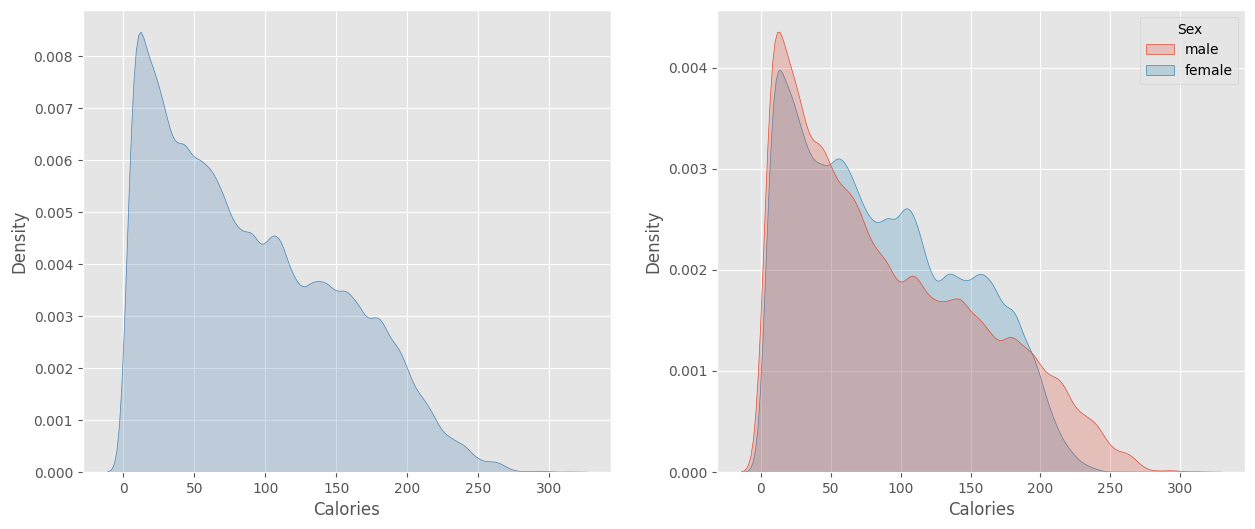

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.kdeplot(ax=axes[0], data=train, x="Calories", fill=True, color="steelblue")
sns.kdeplot(ax=axes[1], data=train, x="Calories", fill=True, hue="Sex")
plt.show();

From the above chart, we see `Calories` is right-skewed. Next, we explore the relationship between `Duration` and `Calories`.

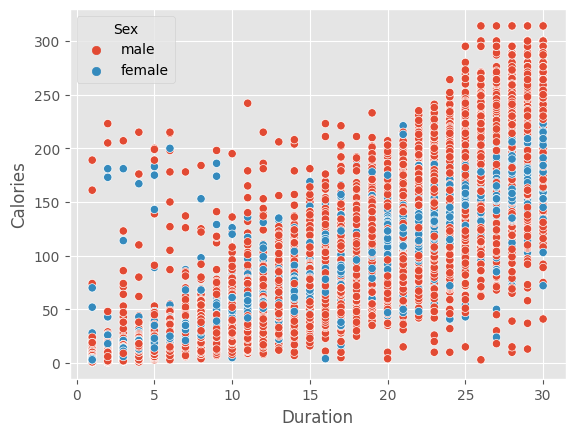

In [4]:
sns.scatterplot(data=train, x='Duration', y="Calories", hue="Sex")
plt.show();

The above chart shows a positive relationship between `Duration` and `Calories`. Also notice that, on average, males tend to burn more calories than females for the same duration value.

# Baseline Modeling 1.0

In this section, we train a couple of models with minimum data preprocessing.

In [5]:
%%time
def rmsle(actual_values, predicted_values):
    
    # Ensure the inputs are numpy arrays
    actual_values = np.array(actual_values)
    predicted_values = np.array(predicted_values)
    
    # Ensure that input values are non-negative
    if (actual_values < 0).any() or (predicted_values < 0).any():
        raise ValueError("RMSLE cannot be used with negative values")
    
    # Add a small constant to avoid log(0) errors, and calculate the squared logarithmic errors
    squared_log_errors = (np.log1p(predicted_values) - np.log1p(actual_values))**2
    
    # Calculate the mean of the squared logarithmic errors
    mean_squared_log_error = np.mean(squared_log_errors)
    
    # Return the square root of the mean squared logarithmic error
    return np.sqrt(mean_squared_log_error)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.06 µs


In [6]:
%%time
X = train.drop(columns=["Calories"], axis=1)
X["Sex"] = X["Sex"].astype("category")
y = train["Calories"]

test["Sex"] = test["Sex"].astype("category")

skf = RepeatedKFold(n_splits=5, n_repeats=1, random_state=42)
cat_features = ['Sex']

CPU times: user 60.1 ms, sys: 6.01 ms, total: 66.1 ms
Wall time: 65.1 ms


In [7]:
%%time
scores, test_preds = [], []
for i, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
    dvalid = xgb.DMatrix(X_val, label=y_val, enable_categorical=True)
    dtest = xgb.DMatrix(test, enable_categorical=True)

    xgb_md = xgb.train({'device': "cuda",
                        # "objective": "reg:squaredlogerror",
                        'learning_rate': 0.05,             
                        'max_depth': 10,                   
                        'colsample_bytree': 0.8,                     
                        'reg_lambda': 8,                     
                        'subsample': 1,                 
                        'reg_alpha': 1, 
                        'n_jobs': -1}, 
                        dtrain, 
                        num_boost_round=500, 
                        evals=[(dvalid, 'validation')], 
                        # early_stopping_rounds=100,
                        verbose_eval=False)
    xgb_pred = xgb_md.predict(dvalid)

    score = rmsle(y_val, xgb_pred)
    print(f"Fold {i + 1} RMSLE: {score:.4f}")
    scores.append(score)

    test_preds.append(xgb_md.predict(dtest))

print(f"CV RMSLE: {np.mean(scores):.4f} ± {np.std(scores):.4f}")

Fold 1 RMSLE: 0.0602
Fold 2 RMSLE: 0.0607
Fold 3 RMSLE: 0.0602
Fold 4 RMSLE: 0.0615
Fold 5 RMSLE: 0.0607
CV RMSLE: 0.0607 ± 0.0005
CPU times: user 35.4 s, sys: 990 ms, total: 36.4 s
Wall time: 34.3 s


In [8]:
%%time
submission = pd.read_csv('../input/playground-series-s5e5/sample_submission.csv')
submission["Calories"] = np.mean(test_preds, axis=0)
submission.head()

CPU times: user 44.4 ms, sys: 16 µs, total: 44.4 ms
Wall time: 73.8 ms


,id,Calories
0,750000,26.946615
1,750001,106.953430
2,750002,87.833763
3,750003,125.863480
4,750004,75.891640


In [9]:
submission.to_csv("baseline_sub_1.csv", index=False)